# EVALUATING CLOSED LOOP SYSTEMS

This notebook illustrates how to construct closed loop systems for ``NonlinearIOSystem`` elements,
including noise and disturbances.

# Preliminaries

In [1]:
!pip install -q control
!pip install -q tellurium
!pip install -q controlSBML

import collections
import control
import controlSBML as ctl
from IPython.display import HTML, Math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy
import tellurium as te

In [26]:
class Parameters(object):
    
    def __init__(self, noise_amp=1, noise_frq=1, disturbance_amp=1, disturbance_frq=1,
                 system_a=0.5):
        self.noise_amp = noise_amp
        self.noise_frq = noise_frq
        self.disturbance_amp = disturbance_amp
        self.disturbance_frq = disturbance_frq
        self.system_a = system_a

In [27]:
TIMES = ctl.makeSimulationTimes(0, 5, 500)
# Default parameters
PARAMETERS = Parameters(
    noise_amp = 1,
    noise_frq = 1,
    disturbance_amp = 1,
    disturbance_frq = 1,
    system_a = -2,
)
PARAMETERS = Parameters()  # Globally specified parameter values

# Helpers

OK!


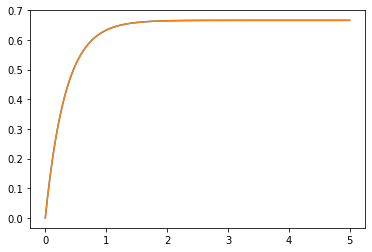

In [49]:
def plotStep(sys, is_plot=True):
    """
    Plots a transfer function step response
    
    Parameters
    ----------
    sys: control.TransferFunction/control.NonlinearIOSystem
    
    Returns
    control.Timeresponse
    """
    if "TransferFunction" in str(type(sys)):
        result = control.forced_response(sys, T=TIMES, U=1)
    elif "NonlinearIOSystem" in str(type(sys)):
        result = control.input_output_response(sys, T=TIMES, U=1)
    if is_plot:
        plt.plot(TIMES, result.outputs.flatten())
    return result

# TESTS
Gs = control.TransferFunction([2], [1, 3])
_ = plotStep(Gs, is_plot=True)
ctlsb = ctl.ControlSBML(MODEL, input_names=["S2"], output_names=["S3"])
ctlsb.set(CONSTANT_DCT)
sys = ctlsb.makeNonlinearIOSystem("sys")
result = plotStep(sys, is_plot=True)
print("OK!")

In [51]:
result.outputs

array([0.        , 0.00398802, 0.00795219, ..., 0.66643059, 0.66643192,
       0.6664333 ])

In [4]:
def pp(obj):
    """
    Does a LaTex rendering of an object with a latex representation.

    Parameters
    ----------
    obj: object
    """
    display(Math(str(obj)))

# Tests
pp(r"e^{\alpha}")

<IPython.core.display.Math object>

# Antimony Model

In [5]:
# Constants
CONSTANT_DCT = {"k1": 1, "k2": 2, "k3": 3, "k4": 4}
s = sympy.Symbol("s")
REF = 10

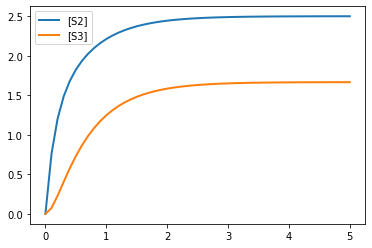

In [6]:
MODEL = """
$S1 -> S2; k1*$S1
J1: S2 -> S3; k2*S2
J2: S3 -> S2; k3*S3
J3: S2 -> ; k4*S2

k1 = 0
k2 = 0
k3 = 0
k4 = 0
$S1 = 10
S2 = 0
S3 = 0
S4 = 0
"""
RR = te.loada(MODEL)
for k in CONSTANT_DCT.keys():
    RR[k] = CONSTANT_DCT[k]
RR.simulate()
RR.plot()

# Closed Loop Transfer Functions

<img src="https://github.com/joseph-hellerstein/advanced-controls-lectures/blob/main/Lecture_13_14-Closed-Loop-Systems/Closed-Loop-System.png?raw=true"
     alt="Markdown Monster icon" width=600pt
     style="float: left; margin-right: 10px;" />
     
**Transfer Functions**
\begin{eqnarray}
H_{RY}(s) & = & \frac{Y(s)}{R(s)} & = & \frac{C(s) G(s)}{1 + C(s) G(s) F(s)} \\
H_{RE}(s) & = & \frac{E(s)}{R(s)} & = & \frac{1}{1 + C(s) G(s) F(s)} \\
H_{NY}(s) & = & \frac{Y(s)}{N(s)} & = & -\frac{ F(s)}{1 + C(s) G(s) F(s)} \\
H_{DY}(s) & = & \frac{Y(s)}{D(s)} & = & \frac{ C(s)}{1 + C(s) G(s) F(s)} \\
\end{eqnarray}

# Elements of Closed Loop System

## System Under Control

In [136]:
ctlsb = ctl.ControlSBML(MODEL, input_names=["S2"], output_names=["S3"])
SYSTEM = ctlsb.makeNonlinearIOSystem("system")

## Controller

In [155]:
def makeController(name, kp=2):
    """
    Creates a proportional controller as a NonlinearIOSystem with input "in" and output "out".
    
    Parameters
    ----------
    name: str
        Name of the system
    kp: float
    
    Returns
    -------
    control.NonlinearIOSystem
    """
    def outfcn(_, __, u, ___):
        # u: float (error signal)
        if not "len" in dir(u):
            u = [u]
        return kp*(- u[0])
    #
    return control.NonlinearIOSystem(
        None, outfcn, inputs=['in'], outputs=['out'],
        name=name)

# Tests
kp = 2
controller = makeController("controller", kp=kp)
times = [0, 1, 2, 3, 4]
result = control.input_output_response(controller, T=times, U=times)
trues = [r == kp*(- t) for t, r in zip(result.t, result.outputs)]
assert(all(trues))
print("OK!")

OK!


## Noise and Disturbanes

In [104]:
def makeSinusoidSystem(name, amp, frequency):
    """
    Construct a NonlinearIOSystem for a sinusoid.
    The system has output "out".
    
    Parameters
    ----------
    name: str
    amp: float
    frequency: float
    
    Returns
    -------
    NonlinearIOSystem
    """
    def outfcn(time, _, __, ___):
        """
        Creates a sine wave at the frequency specified.

        Parameters
        ----------
        time: float
        """
        return amp*np.sin(time*frequency)
    #
    return control.NonlinearIOSystem(
        None, outfcn, outputs=['out'], inputs=[],
        name=name)

# Tests
sys = makeSinusoidSystem("sine", 10, 20)
result = control.input_output_response(sys, T=TIMES)
assert(len(result.y) > 0)
print("OK!")

OK!


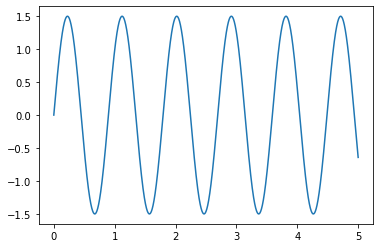

In [38]:
noise = makeSinusoidSystem("noise", 1.5, 7)
result = control.input_output_response(noise, T=TIMES)
plt.plot(result.t, result.y.flatten())

## Summation

In [105]:
def makeSumSystem(name):
    """
    Inputs two elements. Outputs their sum. Name is "sum".
    
    Parameters
    ----------
    name: str
    
    Returns
    -------
    NonlinearIOSystem
    """
    def outfcn(_, __, u, ___):
        """
        Creates a sine wave at the frequency specified.

        Parameters
        ----------
        u: float, float
        """
        return u[0] + u[1]
    #
    return control.NonlinearIOSystem(
        None, outfcn, inputs=["in1", "in2"], outputs=['out'],
        name=name)

# Tests
summer = makeSumSystem("summer")
times = [0, 1, 2, 3, 4]
u_arr = np.array([[t, t] for t in times])
u_arr = u_arr.transpose()
result = control.input_output_response(summer, T=times, U=u_arr)
trues = [r == 2*t for t, r in zip(times, result.outputs.flatten())]
assert(all(trues))
print("OK!")

OK!


## Filter

In [141]:
def makeFilterSystem(name, constant):
    """
    Construct a NonlinearIOSystem for x' = a*x + u.
    The system has input "in" and output "out".
    
    Parameters
    ----------
    name: str
    constant: float
        e**expo_constant*time
    
    Returns
    -------
    NonlinearIOSystem
    """
    def updfcn(time, x_vec, u_vec, ___):
        """
        Creates a sine wave at the frequency specified.

        Parameters
        ----------
        time: float
        x_vec: float
        u_vec: float
        """
        if not "len" in dir(x_vec):
            x_vec = [x_vec]
        if not "len" in dir(u_vec):
            u_vec = [u_vec]
        return constant*x_vec[0] + u_vec[0]
    def outfcn(_, x_vec, __, ___):
        return x_vec[0]
    #
    return control.NonlinearIOSystem(
        updfcn, outfcn, outputs=['out'], inputs=["in"], states=["x"],
        name=name)

# Tests
sys = makeFilterSystem("filter", 1)
result = control.input_output_response(sys, T=TIMES, X0=[10])
assert(len(result.y) > 0)
print("OK!")

OK!


In [126]:
def makeConstantSystem(name, constant):
    """
    Outputs a constant value.
    
    Parameters
    ----------
    name: str
    constant: float
    
    Returns
    -------
    NonlinearIOSystem
    """
    def outfcn(_, __, ___, ____):
        return constant
    #
    return control.NonlinearIOSystem(
        None, outfcn, outputs=['out'], inputs=[], name=name)

# Tests
constant = 3
sys = makeConstantSystem("constant", constant)
result = control.input_output_response(sys, T=TIMES)
assert(np.var(result.y) == 0)
assert(result.y.flatten()[0] == constant)
print("OK!")

OK!


# Closed Loop System With Noise and Disturbances

<img src="https://github.com/joseph-hellerstein/advanced-controls-lectures/blob/main/Lecture_13_14-Closed-Loop-Systems/Closed-Loop-System.png?raw=true"
     alt="Markdown Monster icon" width=600pt
     style="float: left; margin-right: 10px;" />

In [157]:
# Create the closed loop system
ref = 3
controller = makeController("controller", kp=2)
noise = makeSinusoidSystem("noise", 0.2, 20)
disturbance = makeSinusoidSystem("disturbance", 0.2, 2)
fltr = makeFilterSystem("fltr", -2)
r_sys = makeConstantSystem("r_sys", ref)
sum_Y_N = makeSumSystem("sum_Y_N")
sum_U_D = makeSumSystem("sum_U_D")
sum_R_F = makeSumSystem("sum_R_F")

closed_loop = control.interconnect(
  [noise, disturbance, sum_Y_N, sum_R_F, sum_U_D, r_sys, SYSTEM, fltr, controller ], 
  connections=[
    ['controller.in', 'sum_R_F.out'],    # e(t)
    ['sum_U_D.in1', 'controller.out'],   # u(t)
    ['sum_U_D.in2', 'disturbance.out'],  # d(t)
    ['system.S2',   'sum_U_D.out'],
    ['sum_Y_N.in1', 'system.S3'],        # y(t)
    ['sum_Y_N.in2', 'noise.out'],        # n(t)
    ['fltr.in',     'sum_Y_N.out'],
    ['sum_R_F.in1', '-fltr.out'],
    ['sum_R_F.in2', 'r_sys.out'],
  ],
  outlist=["sum_Y_N.out", 'sum_R_F.out'],
)

(-5.0, 5.0)

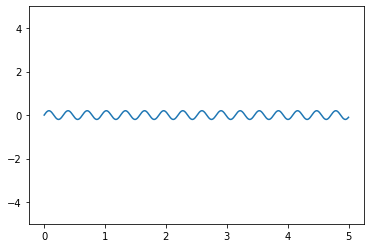

In [158]:
result = control.input_output_response(closed_loop, T=TIMES)
plt.plot(TIMES, result.outputs[0].flatten())
#plt.plot(TIMES, result.outputs[1].flatten())
plt.ylim([-5, 5])

The output is biased! We wanted $S_3$ to be 10, but it's 7.6.

# Problem Statement

We want to evaluate the transfer functions for a variety of systems $C(s)$ and filters $F(s)$.
We will use $G(s) = \frac{2}{s + 3}$, $C(s) = k_p$, and $F(s) = \frac{k_f}{s + k_f}$.

1. Create an experimental infrastructure, codes that creates a plot with a line for each of the transfer functions. You wil need to create the transfer functions C(s), G(s), F(s). The plot should have a legend.
    1. Inputs: G_tf (transfer function for G(s)), k_p, k_f
1. Construct 4 plots such that $k_p \in \{1, 10\}$, $k_f \in \{1, 10\}$.
1. Discuss the tradeoffs between large and small values of $k_p$, $k_f$?

# Experimental Infrastructure

In [ ]:
def plotTFs(Gs, k_p, k_f, times=TIMES, ylim=None, title=None, is_plot=True):
    """
    Constructs the transfer functions for the proportional controller, and filter.
    Calculates the transfer functions HRYs, HREs, HNYs, HDYs and plots them.
    
    Parameters
    ----------
    Gs: control.TransferFunction
    k_pf: float
    k_f: float
    times: list-float
    ylim: (float, float)
        limits of y-values
    title: str
    
    Returns
    -------
    dct
        key: name of transfer function
        value: control.TransferFunction
    """
    Cs = control.TransferFunction([k_p], [1])
    Fs = control.TransferFunction([k_f], [1, k_f])
    denom = 1 + Cs*Gs*Fs
    # Construct the transfer functions
    tf_dct = {
        "HRYs": Cs*Gs/denom,
        "HREs": 1/denom,
        "HNYs": -Fs/denom,
        "HDYs": Cs/denom,
    }
    # Construct the plots
    _, ax = plt.subplots(1)
    for tf in tf_dct.values():
        result = control.forced_response(tf, T=TIMES, U=1)
        ax.plot(times, result.outputs)
    ax.plot([0, times[-1]], [1, 1], linestyle="--")
    ax.plot([0, times[-1]], [0, 0], linestyle="--")
    ax.legend(tf_dct.keys())
    ax.set_ylabel("value")
    ax.set_xlabel("time")
    if ylim is not None:
        ax.set_ylim(ylim)
    if title is not None:
        ax.set_title(title)
    if not is_plot:
        plt.close()
    return tf_dct
    
# Tests
Gs = control.TransferFunction([2], [1, 3])
dct = plotTFs(Gs, 10, 10, ylim=[0, 3], title="Example", is_plot=False)
print("OK!")